<a href="https://colab.research.google.com/github/lucavgn/AML_Project5/blob/main/Project5_centralized_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%writefile centralized-training.py

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Training settings
epochs = 150 #should be 150 but it takes too much time to run the code
batch_size = 128
momentum = 0.9
weight_decay = 1e-2

# Define LeNet-5 architecture
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # First convolutional layer: takes 3 input channels, outputs 64 features, kernel size = 5
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.relu1 = nn.ReLU()  # ReLU activation after first convolution
        self.pool1 = nn.MaxPool2d(2, 2)  # Max pooling layer with 2x2 kernel size

        # Second convolutional layer: takes 64 input channels, outputs 64 features, kernel size = 5
        self.conv2 = nn.Conv2d(64, 64, 5)
        self.relu2 = nn.ReLU()  # ReLU activation after second convolution
        self.pool2 = nn.MaxPool2d(2, 2)  # Max pooling layer with 2x2 kernel size

        # Fully connected layer 1: input = 64 * 5 * 5 (flattened features from previous pooling), output = 384
        self.fc1 = nn.Linear(64 * 5 * 5, 384)
        # self.dropout1 = nn.Dropout(0.5)  # Dropout layer with 50% dropout rate
        self.relu3 = nn.ReLU()  # ReLU activation after fully connected layer 1

        # Fully connected layer 2: input = 384, output = 192
        self.fc2 = nn.Linear(384, 192)
        self.relu4 = nn.ReLU()  # ReLU activation after fully connected layer 2

        # Softmax classifier: input = 192, output = 100 (for CIFAR-100 classes)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))  # First convolutional block
        x = self.pool2(self.relu2(self.conv2(x)))  # Second convolutional block
        x = x.view(-1, 64 * 5 * 5)  # Flatten the output from the second convolutional block
        x = self.relu3(self.fc1(x))  # Fully connected layer 1
        # x = self.relu3(self.dropout1(self.fc1(x)))
        x = self.relu4(self.fc2(x))  # Fully connected layer 2
        x = self.fc3(x)  # Final softmax layer for output
        return x

# Load CIFAR-100 dataset
transform = transforms.Compose([transforms.ToTensor(),  # Convert images to PyTorch tensors
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # Normalize images to the range [0, 1]

# Dataset for training the model
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Dataset for testing the model
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Device setup: use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model and move it to the device
net_sgdm = LeNet5().to(device)
net_adamw = LeNet5().to(device)

# Define the criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Optimizer settings
sgdm_optimizer = optim.SGD(net_sgdm.parameters(), lr=0.01, momentum=momentum, weight_decay=weight_decay)  # SGDM Optimizer
adamw_optimizer = optim.AdamW(net_adamw.parameters(), lr=1e-4, weight_decay=weight_decay)  # AdamW Optimizer

# Learning Rate Scheduler
scheduler_sgdm = optim.lr_scheduler.CosineAnnealingLR(sgdm_optimizer, T_max=150)  # SGDM LR Scheduler
scheduler_adamw = optim.lr_scheduler.CosineAnnealingLR(adamw_optimizer, T_max=150)  # AdamW LR Scheduler

# Function to train the model
def train_model(optimizer, scheduler, model, criterion, trainloader, testloader, device, epochs):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100. * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluate on test set
        model.eval()
        correct_test = 0
        total_test = 0
        test_loss = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total_test += labels.size(0)
                correct_test += predicted.eq(labels).sum().item()

        test_loss = test_loss / len(testloader)
        test_losses.append(test_loss)
        test_accuracy = 100. * correct_test / total_test
        test_accuracies.append(test_accuracy)

        # Step the scheduler
        scheduler.step()

        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')

    return train_losses, test_losses, train_accuracies, test_accuracies

# # Train with SGDM
# print("--- Train with SGDM ---")
# sgdm_train_loss, sgdm_test_loss, sgdm_train_acc, sgdm_test_acc = train_model(
#     sgdm_optimizer, scheduler_sgdm, net_sgdm, criterion, trainloader, testloader, device, epochs
# )

# # Save model SGDM
# torch.save(net_sgdm.state_dict(), 'net_sgdm_epoch5.pth')

# Train with AdamW

print("--- Train with AdamW ---")
adamw_train_loss, adamw_test_loss, adamw_train_acc, adamw_test_acc = train_model(
    adamw_optimizer, scheduler_adamw, net_adamw, criterion, trainloader, testloader, device, epochs
)

# Save model AdamW
torch.save(net_adamw.state_dict(), 'net_adamw_epoch5.pth')

# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
# plt.plot(sgdm_train_loss, label='SGDM Train Loss')
plt.plot(adamw_train_loss, label='AdamW Train Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(2, 2, 2)
# plt.plot(sgdm_test_loss, label='SGDM Test Loss')
plt.plot(adamw_test_loss, label='AdamW Test Loss')
plt.title('Test Loss')
plt.legend()

plt.subplot(2, 2, 3)
# plt.plot(sgdm_train_acc, label='SGDM Train Accuracy')
plt.plot(adamw_train_acc, label='AdamW Train Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
# plt.plot(sgdm_test_acc, label='SGDM Test Accuracy')
plt.plot(adamw_test_acc, label='AdamW Test Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
# Save plot as image
plt.savefig('plot_epoch5.png')



Overwriting centralized-training.py


# New section

Files already downloaded and verified
Files already downloaded and verified
--- Train with AdamW ---
Epoch 1/150, Loss: 4.2709, Train Acc: 5.34%, Test Acc: 8.02%
Epoch 2/150, Loss: 3.9616, Train Acc: 9.58%, Test Acc: 10.55%
Epoch 3/150, Loss: 3.8044, Train Acc: 12.21%, Test Acc: 13.16%
Epoch 4/150, Loss: 3.6795, Train Acc: 14.09%, Test Acc: 14.67%
Epoch 5/150, Loss: 3.5795, Train Acc: 15.85%, Test Acc: 16.37%
Epoch 6/150, Loss: 3.4956, Train Acc: 17.27%, Test Acc: 17.16%
Epoch 7/150, Loss: 3.4317, Train Acc: 18.15%, Test Acc: 18.16%
Epoch 8/150, Loss: 3.3677, Train Acc: 19.47%, Test Acc: 19.37%
Epoch 9/150, Loss: 3.3147, Train Acc: 20.45%, Test Acc: 20.38%
Epoch 10/150, Loss: 3.2630, Train Acc: 21.39%, Test Acc: 21.76%
Epoch 11/150, Loss: 3.2262, Train Acc: 22.15%, Test Acc: 22.37%
Epoch 12/150, Loss: 3.1791, Train Acc: 23.00%, Test Acc: 22.87%
Epoch 13/150, Loss: 3.1501, Train Acc: 23.42%, Test Acc: 23.23%
Epoch 14/150, Loss: 3.1106, Train Acc: 24.24%, Test Acc: 24.67%
Epoch 15/150, L

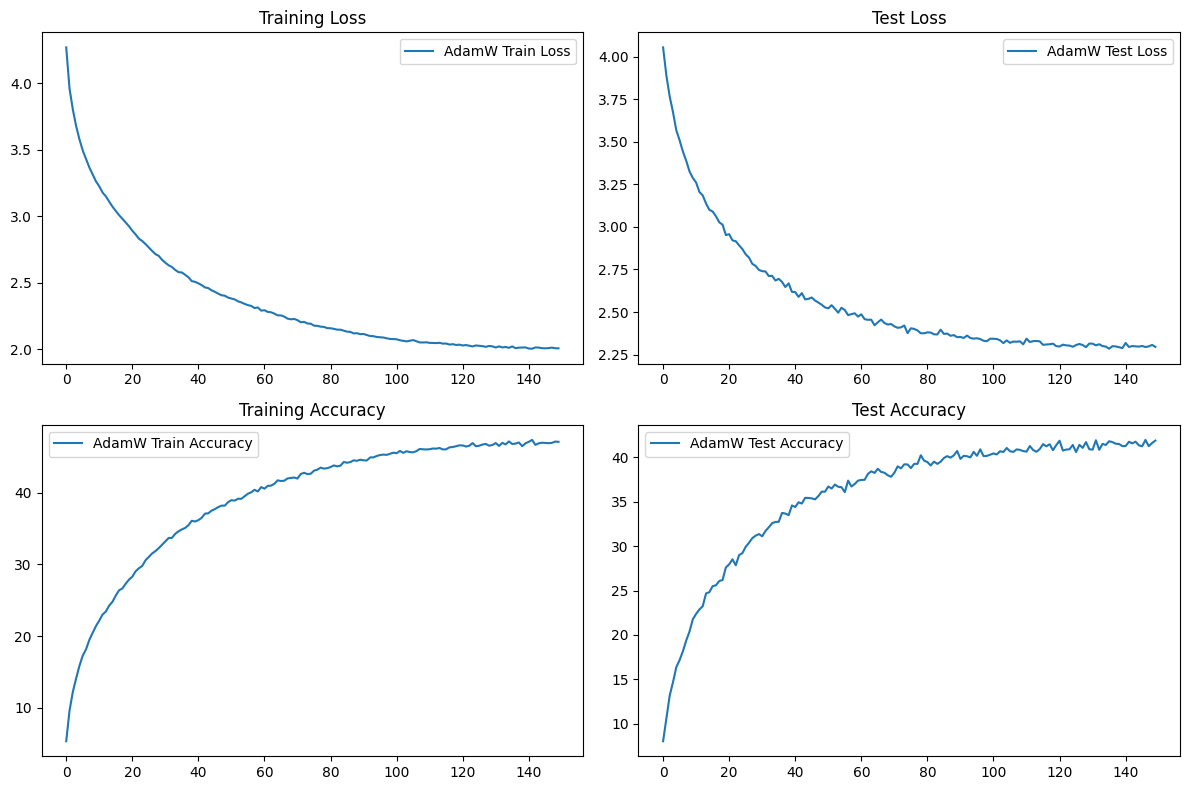

In [ ]:
%run centralized-training.py